In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
#%% Utility Functions
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor

In [4]:
!ls {dataroot}

model_outputs
nsd_shared1000_6monkeys_2024.h5
paul_240713-240710
paul_240713-240710_trial_resp_tensor.npy
paul_240713-240710_trial_resp_tensor_train_test_idx.npz
paul_denoised.npy
shared1000_images.tar.gz
Stimuli
vvs-accentuate-day1_normalize_paul_241119-241122.h5
vvs-accentuate-day1_normalize_paul_241119.h5
vvs-accentuate-day1_raw_paul_241119-241122.h5
vvs-accentuate-day2_normalize_paul_241120.h5
vvs-accentuate-day3_normalize_paul_241124-25.h5


In [5]:
#%% Utility Functions
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
data_path = join(dataroot, "vvs-accentuate-day3_normalize_paul_241124-25.h5")
data = load_from_hdf5(data_path)

In [8]:
list(data.keys())

['paul_20241124-20241125', 'paul_241123-241124']

In [30]:
subjects = list(data.keys())
subject_id = 'paul_20241124-20241125'#'paul_241123-241124'
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id, )

Trials shape: (2487,) (2487, 64)
Rspavg shape: (1300,) (1300, 64)
Response tensor shape (stimulus x neuron x trial): (1300, 64, 3)
Response tensor shape: (1300, 64, 3)
Trial counters shape: (1300,)
min and max trial counters: 1 3


In [31]:
stim_names_str = [stim_names[i].decode('utf-8') for i in range(len(stim_names))]


In [32]:
stim_names_str

['r50_unit_25_img_0_level_-0.36653251647949214_score_-0.3582078814506531.png',
 'r50_unit_25_img_0_level_-1.0111116826534272_score_-1.0028517246246338.png',
 'r50_unit_25_img_0_level_-1.655690848827362_score_-1.6483879089355469.png',
 'r50_unit_25_img_0_level_0.2780466496944429_score_0.27167457342147827.png',
 'r50_unit_25_img_0_level_0.9226258158683778_score_0.9140704870223999.png',
 'r50_unit_25_img_0_level_1.5672049820423126_score_1.5650928020477295.png',
 'r50_unit_25_img_0_level_2.211784148216248_score_2.207993745803833.png',
 'r50_unit_25_img_0_level_2.8563633143901823_score_2.849501609802246.png',
 'r50_unit_25_img_0_level_3.5009424805641176_score_3.4944045543670654.png',
 'r50_unit_25_img_0_level_4.145521646738053_score_4.147982120513916.png',
 'r50_unit_25_img_0_level_4.790100812911987_score_4.78483247756958.png',
 'r50_unit_25_img_1_level_-0.36653251647949214_score_-0.3627781867980957.png',
 'r50_unit_25_img_1_level_-1.0111116826534272_score_-1.007502794265747.png',
 'r50_uni

In [42]:
import re
import pandas as pd
pattern = r'(robust_r50|r50)_unit_(\d+)_img_(\d+)_level_([-\d.]+)_score_([-\d.]+)\.png'
# go through stim_names_str, find the pattern, and extract the unit number
acc_stim_names = []
acc_params = []
for i, stim_name in enumerate(stim_names_str):
    match = re.search(pattern, stim_name)
    if match:
        acc_stim_names.append(stim_name)
        unit_id = int(match.group(2))
        acc_params.append({
            "model": match.group(1),
            "unit": unit_id,
            "img": int(match.group(3)),
            "ctrl_level": float(match.group(4)),
            "acc_level": float(match.group(5)),
            "stim_name": stim_name,
            "index": i, 
            "rspavg_resp_peak": rspavg_resp_peak[i, unit_id],
        })

acc_param_df = pd.DataFrame(acc_params)

In [39]:
acc_param_df.model.unique()

array(['r50', 'robust_r50'], dtype=object)

In [43]:
acc_param_df

,model,unit,img,ctrl_level,acc_level,stim_name,index,rspavg_resp_peak
0,r50,25,0,-0.366533,-0.358208,r50_unit_25_img_0_level_-0.36653251647949214_s...,0,0.444603
1,r50,25,0,-1.011112,-1.002852,r50_unit_25_img_0_level_-1.0111116826534272_sc...,1,-0.781395
2,r50,25,0,-1.655691,-1.648388,r50_unit_25_img_0_level_-1.655690848827362_sco...,2,-0.162387
3,r50,25,0,0.278047,0.271675,r50_unit_25_img_0_level_0.2780466496944429_sco...,3,-0.246210
4,r50,25,0,0.922626,0.914070,r50_unit_25_img_0_level_0.9226258158683778_sco...,4,-0.053700
...,...,...,...,...,...,...,...,...
1095,robust_r50,8,9,2.378011,2.369042,robust_r50_unit_8_img_9_level_2.37801055908203...,1095,1.791413
1096,robust_r50,8,9,2.993517,2.984022,robust_r50_unit_8_img_9_level_2.99351692795753...,1096,1.797466
1097,robust_r50,8,9,3.609023,3.599594,robust_r50_unit_8_img_9_level_3.60902329683303...,1097,2.162581
1098,robust_r50,8,9,4.224530,4.036341,robust_r50_unit_8_img_9_level_4.22452966570854...,1098,1.297095


In [36]:
acc_param_df.unit.unique()

array([25, 36, 40, 47,  8])

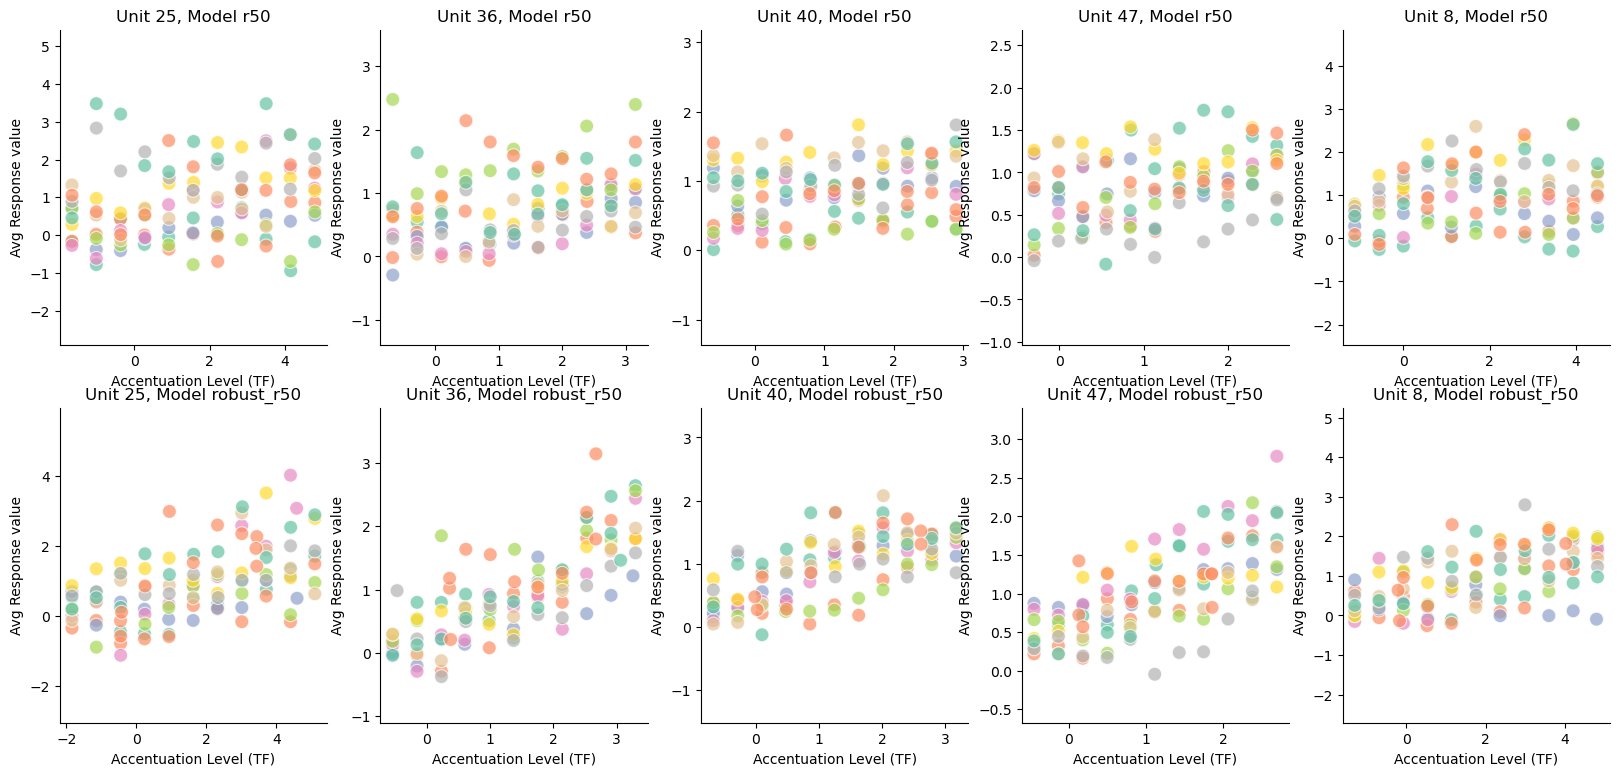

In [57]:
fig, axs = plt.subplots(2, 5, figsize=(20, 9))
for axi, unit_id in enumerate(acc_param_df.unit.unique()):
    for axj, model in enumerate(acc_param_df.model.unique()):
        sns.scatterplot(x="acc_level", y="rspavg_resp_peak", 
                        data=acc_param_df.query(f"unit == {unit_id} and model == '{model}'"),
                        hue="img", palette="Set2",legend=False,
                        markers=["o", "s"],  # palette="", 
                    alpha=0.7, s=100, ax=axs[axj, axi])
        axs[axj, axi].set_title(f"Unit {unit_id}, Model {model}")
        axs[axj, axi].set_xlabel("Accentuation Level (TF)")
        axs[axj, axi].set_ylabel("Avg Response value")
        # axs[axj, axi].legend(title="Image")
        axs[axj, axi].axis("equal")
plt.show()

### Model re-prediction 

In [58]:
def load_model_transform(modelname, device="cuda"):
    # Prepare model and transforms
    if modelname == "resnet50_robust":
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50":
        model = resnet50(pretrained=True)
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50_clip":
        import clip
        model_clip, preprocess = clip.load('RN50', device=device)
        model = model_clip.visual
        transforms_pipeline = preprocess
    elif modelname == "resnet50_dino":
        # https://github.com/facebookresearch/dino
        model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError(f"Unknown model: {modelname}")
        # model = timm.create_model(modelname, pretrained=True).to(device).eval()
        # data_config = timm.data.resolve_model_data_config(model)
        # transforms_pipeline = timm.data.create_transform(**data_config, is_training=False)
    model = model.to(device).eval()
    model.requires_grad_(False)
    
    return model, transforms_pipeline

In [66]:
def rebuild_prediction_pipeline(modelname, layer_name, subject_id, device="cuda",
                                readout_path=None, Xtransform_path=None, meta_path=None, suffix="_pca1000"):
    model_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/"
    if readout_path is None:
        readout_path = join(model_root, subject_id, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{layer_name}{suffix}.pth")
    if Xtransform_path is None:
        Xtransform_path = join(model_root, subject_id, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{layer_name}{suffix}.pkl")
    if meta_path is None:
        meta_path = join(model_root, subject_id, f"{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{layer_name}{suffix}.pkl")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    state_dict = th.load(readout_path)
    readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).to(device)
    readout.load_state_dict(state_dict)
    pca = pkl.load(open(Xtransform_path, "rb"))
    Xtransform = PCA_torch(pca, device=device)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name,  ingraph=True, store_device=device)
    return model, fetcher, transforms_pipeline, readout, Xtransform


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


def build_objective_fn(model, fetcher, readout, Xtransform, layer_name, device="cuda", pred_type="mean"):
    if pred_type == "mean":
        def objective(images):
            model(images)
            feat_tsr = fetcher[layer_name]  # Access the layer4 feature
            feat_vec = Xtransform(feat_tsr)
            return readout(feat_vec).mean(dim=1)
    elif pred_type == "unit":
        def objective(images, unit_id):
            model(images)
            feat_tsr = fetcher[layer_name]  # Access the layer4 feature
            feat_vec = Xtransform(feat_tsr)
            return readout(feat_vec)[:, unit_id]
    elif pred_type == "population":
        def objective(images):
            model(images)
            feat_tsr = fetcher[layer_name]  # Access the layer4 feature
            feat_vec = Xtransform(feat_tsr)
            return readout(feat_vec)
    else:
        raise ValueError(f"Unknown prediction type: {pred_type}")
    
    check_gradient(objective)
    return objective


def build_objective_fn_from_model(modelname, layer_name, subject_id, device="cuda", pred_type="population"):
    model, fetcher, transforms_pipeline, readout, Xtransform = rebuild_prediction_pipeline(modelname, layer_name, subject_id, device=device)
    return build_objective_fn(model, fetcher, readout, Xtransform, layer_name, device=device, pred_type=pred_type), transforms_pipeline


In [71]:
# readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
# Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
modelname = "resnet50_robust"
layer_name = '.layer4.Bottleneck1'
Xtransform_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}/{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl'
readout_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}/{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth' 
meta_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}/{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl'
device = "cuda"
model, transforms_pipeline = load_model_transform(modelname, device=device)
model = model.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)

# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)

# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()


def objective_unit(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 1].mean()


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
check_gradient(objective)


# Define the prediction pipeline
def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)

FileNotFoundError: [Errno 2] No such file or directory: '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241124-20241125/paul_20241124-20241125_resnet50_robust_sweep_regressors_readout_RidgeCV_.layer4.Bottleneck1_pca1000.pth'

In [82]:
layer_name = '.layer4.Bottleneck1'
encoding_subject_id =  'paul_20241119-20241122' 
population_prediction_obj, transforms_pipeline = \
    build_objective_fn_from_model("resnet50_robust", layer_name, encoding_subject_id, device="cuda", pred_type="population")

population_prediction_obj_RN50, transforms_pipeline_RN50 = \
    build_objective_fn_from_model("resnet50", layer_name, encoding_subject_id, device="cuda", pred_type="population")

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 64])


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64])


### Validating Responses to FA2 images

In [74]:
stimdir = "/n/holylabs/LABS/kempner_fellows/Lab/results_22-11-2024"
# list png files in stimdir
png_files = [f for f in os.listdir(stimdir) if f.endswith('.png')]
fa_img_fps = [join(stimdir, f) for f in acc_param_df.stim_name]
for i, fa_img_fp in enumerate(fa_img_fps):
    assert os.path.exists(fa_img_fp), f"File {fa_img_fp} does not exist"

In [83]:
dataset = ImagePathDataset(fa_img_fps, scores=None, transform=transforms_pipeline)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)
population_pred_RN50_robust = []
population_pred_RN50 = []
for batch in tqdm(dataloader):
    with th.no_grad():
        pred_rsp_RN50_robust = population_prediction_obj(batch[0].cuda()).cpu()
        population_pred_RN50_robust.append(pred_rsp_RN50_robust)
        pred_rsp_RN50 = population_prediction_obj_RN50(batch[0].cuda()).cpu()
        population_pred_RN50.append(pred_rsp_RN50)
population_pred_RN50_robust = th.cat(population_pred_RN50_robust, dim=0)
population_pred_RN50 = th.cat(population_pred_RN50, dim=0)
print(population_pred_RN50_robust.shape)

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/35 [00:00<?, ?it/s]

torch.Size([1100, 64])


In [84]:
for i, acc_param in acc_param_df.iterrows():
    unit_id = acc_param.unit
    acc_param_df.loc[i, "enc_pred_RN50_robust"] = population_pred_RN50_robust[i, unit_id].item()
    acc_param_df.loc[i, "enc_pred_RN50"] = population_pred_RN50[i, unit_id].item()
# acc_param_df.to_csv(join(dataroot, "vvs-accentuate-day3_normalize_paul_241121_population_pred.csv"))

In [85]:
acc_param_df

,model,unit,img,ctrl_level,acc_level,stim_name,index,rspavg_resp_peak,enc_pred_RN50_robust,enc_pred_RN50
0,r50,25,0,-0.366533,-0.358208,r50_unit_25_img_0_level_-0.36653251647949214_s...,0,0.444603,0.092934,-0.322379
1,r50,25,0,-1.011112,-1.002852,r50_unit_25_img_0_level_-1.0111116826534272_sc...,1,-0.781395,0.106952,-0.660248
2,r50,25,0,-1.655691,-1.648388,r50_unit_25_img_0_level_-1.655690848827362_sco...,2,-0.162387,0.091897,-1.106562
3,r50,25,0,0.278047,0.271675,r50_unit_25_img_0_level_0.2780466496944429_sco...,3,-0.246210,0.098001,0.172366
4,r50,25,0,0.922626,0.914070,r50_unit_25_img_0_level_0.9226258158683778_sco...,4,-0.053700,0.107106,0.603727
...,...,...,...,...,...,...,...,...,...,...
1095,robust_r50,8,9,2.378011,2.369042,robust_r50_unit_8_img_9_level_2.37801055908203...,1095,1.791413,2.413188,2.156096
1096,robust_r50,8,9,2.993517,2.984022,robust_r50_unit_8_img_9_level_2.99351692795753...,1096,1.797466,2.991391,2.124926
1097,robust_r50,8,9,3.609023,3.599594,robust_r50_unit_8_img_9_level_3.60902329683303...,1097,2.162581,3.469859,2.207771
1098,robust_r50,8,9,4.224530,4.036341,robust_r50_unit_8_img_9_level_4.22452966570854...,1098,1.297095,3.792646,2.113857


In [91]:
df_part["rspavg_resp_peak"]

0      0.444603
1     -0.781395
2     -0.162387
3     -0.246210
4     -0.053700
         ...   
105   -0.024240
106    1.204508
107    1.186047
108    1.864015
109    1.646641
Name: rspavg_resp_peak, Length: 110, dtype: float32

In [93]:
# set type of enc_pred_RN50_robust to float
acc_param_df["enc_pred_RN50_robust"] = acc_param_df["enc_pred_RN50_robust"].astype(float)
acc_param_df["enc_pred_RN50"] = acc_param_df["enc_pred_RN50"].astype(float)
acc_param_df["acc_level"] = acc_param_df["acc_level"].astype(float)

In [101]:
def compute_r2(y, y_pred):
    return 1- ((y - y_pred)**2).sum() / ((y - y.mean())**2).sum()


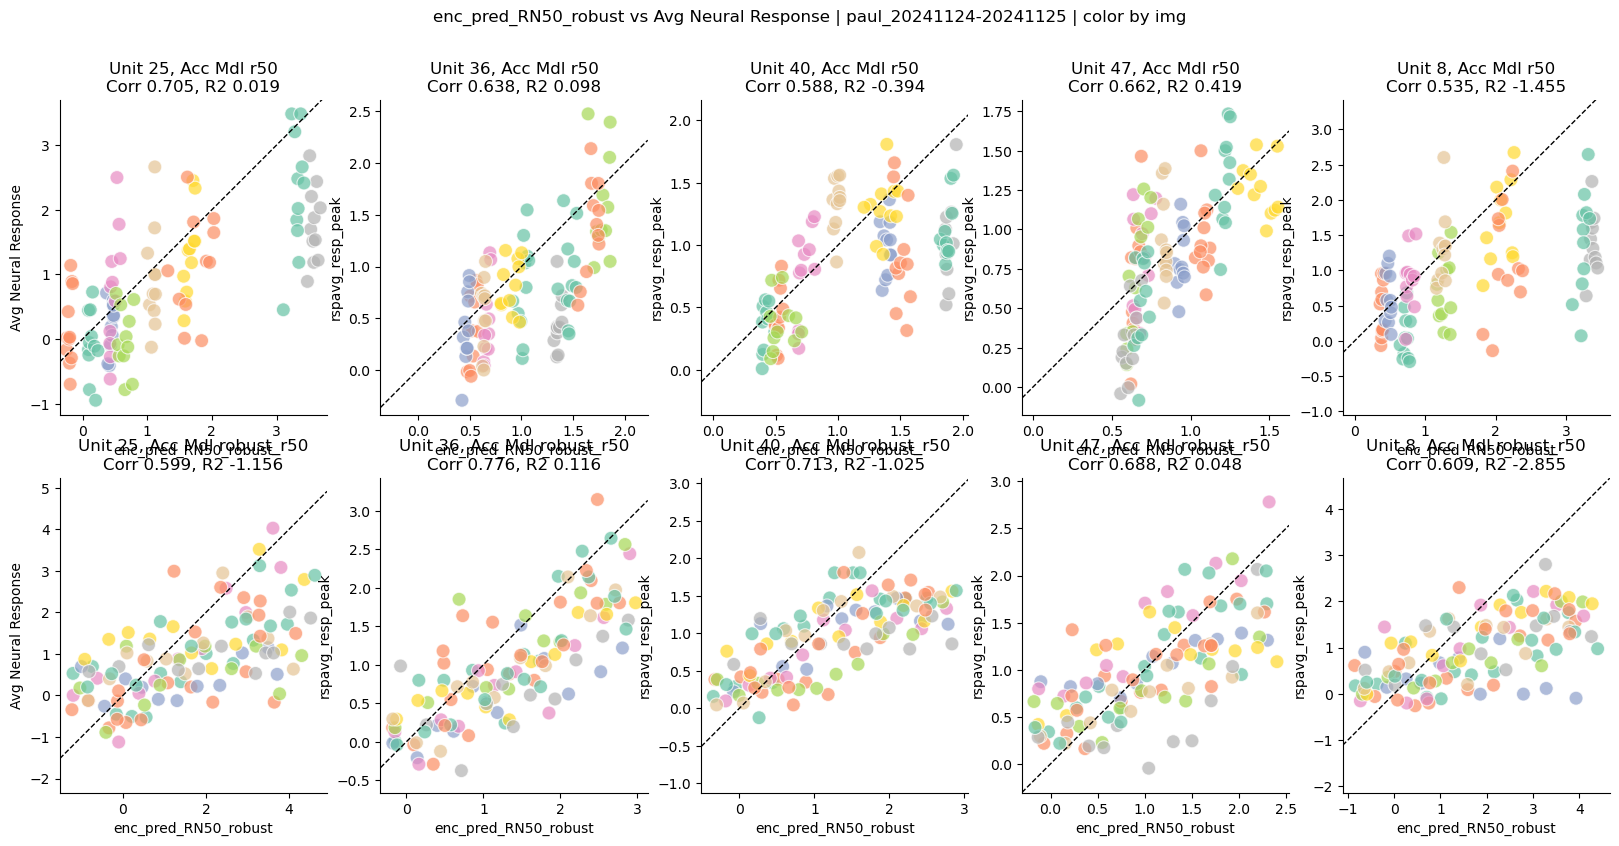

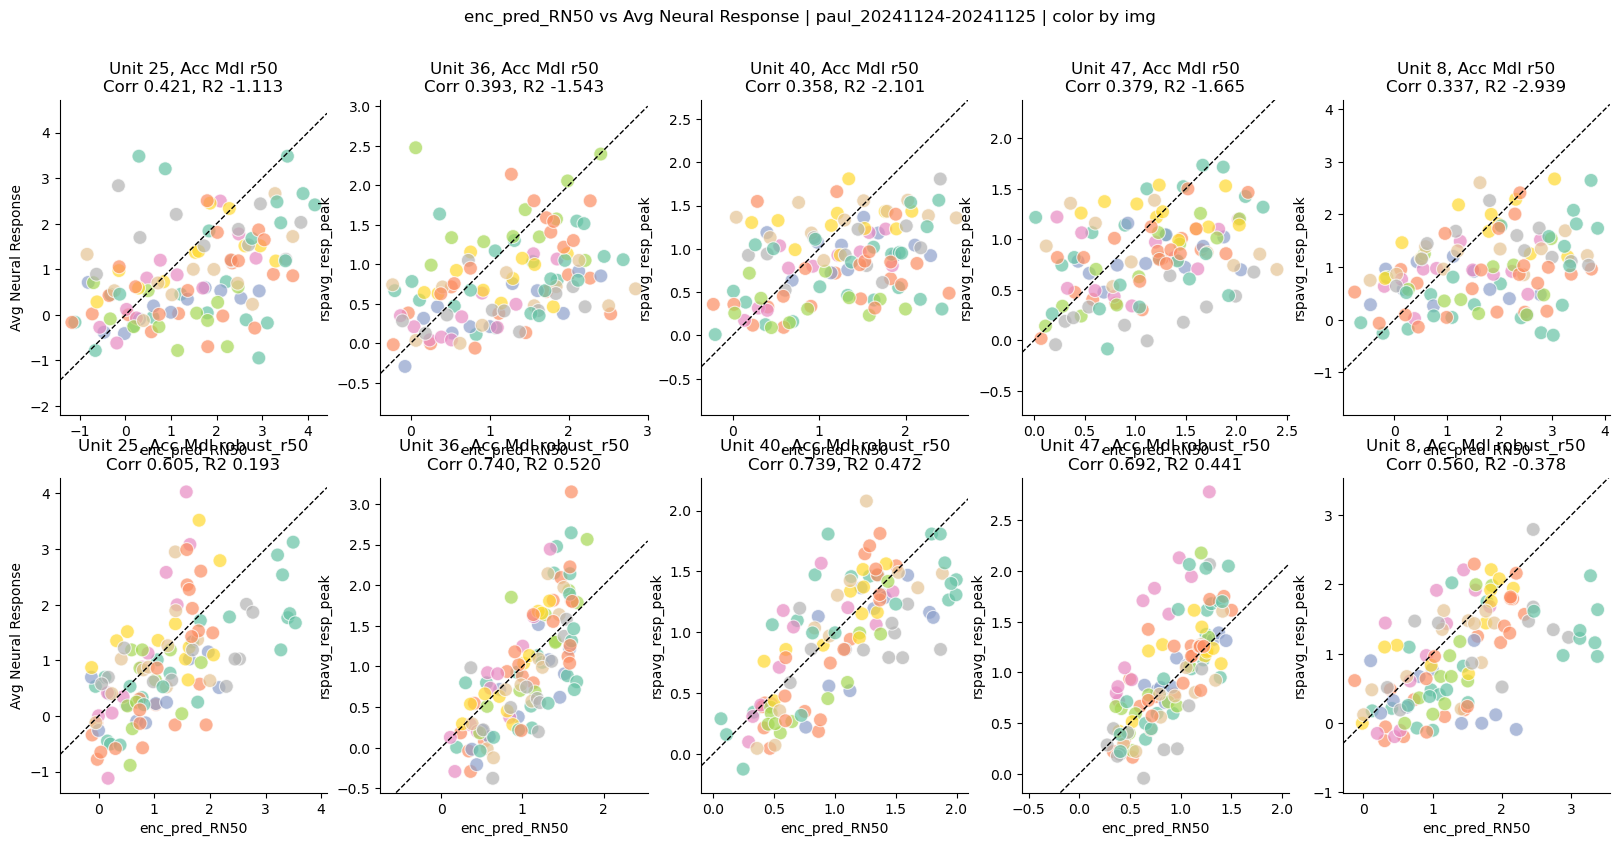

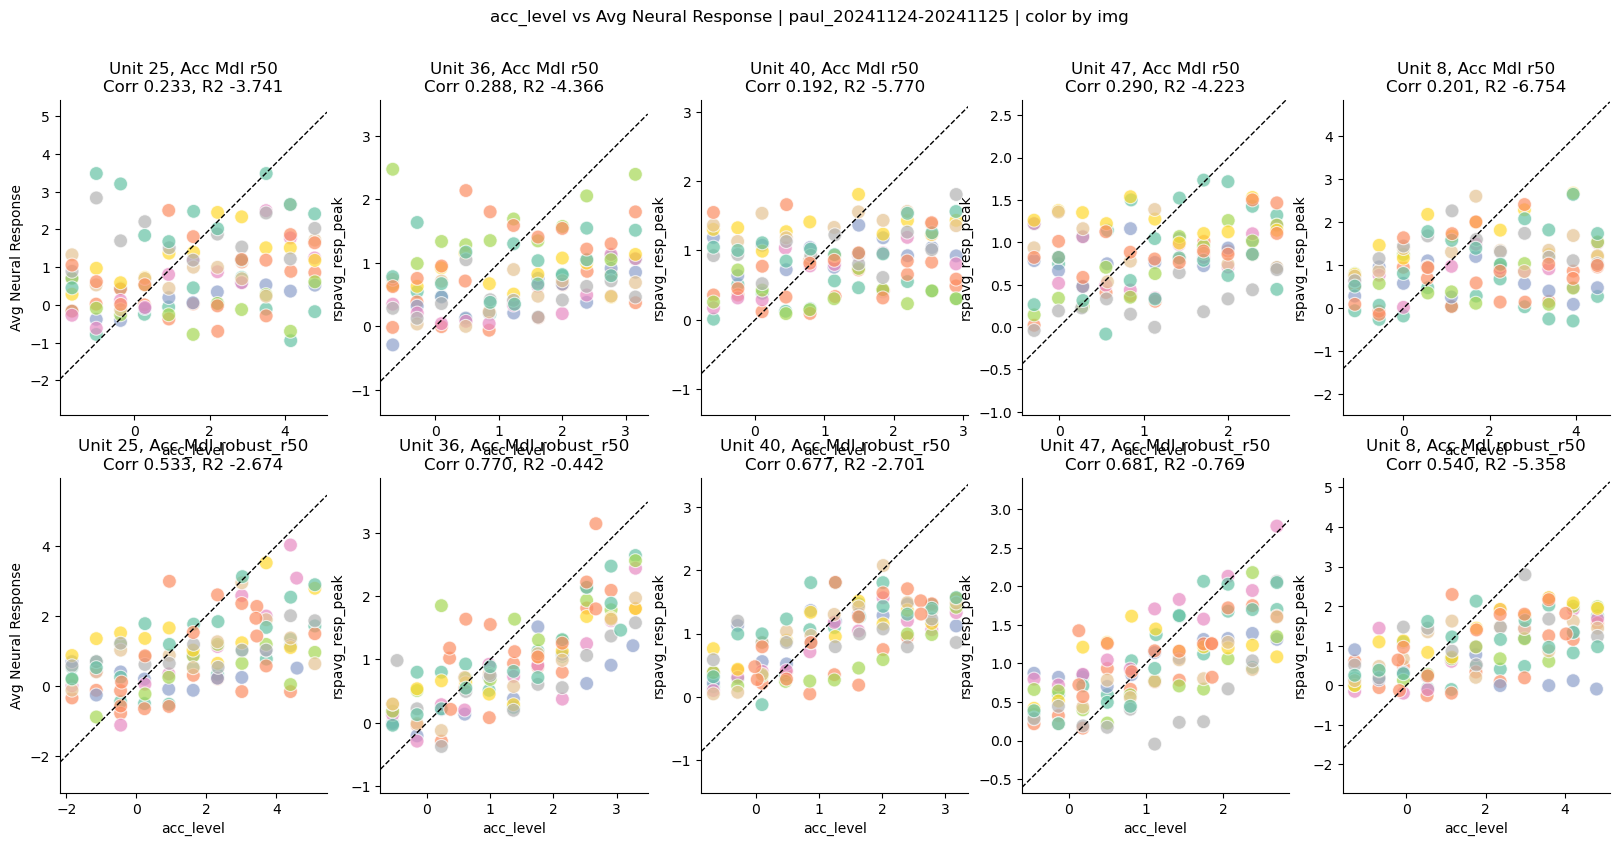

In [105]:
from scipy.stats import pearsonr
for xvariable in ["enc_pred_RN50_robust", "enc_pred_RN50", "acc_level"]:
    fig, axs = plt.subplots(2, 5, figsize=(20, 9))
    for axi, unit_id in enumerate(acc_param_df.unit.unique()):
        for axj, model in enumerate(acc_param_df.model.unique()):
            df_part = acc_param_df.query(f"unit == {unit_id} and model == '{model}'")
            sns.scatterplot(x=xvariable, y="rspavg_resp_peak", 
                            data=df_part,
                            hue="img", palette="Set2",legend=False,
                            markers=["o", "s"],  # palette="", 
                        alpha=0.7, s=100, ax=axs[axj, axi])
            # compute the correlation between xvariable and rspavg_resp_peak
            corr, _ = pearsonr(df_part[xvariable].values, df_part["rspavg_resp_peak"].values)
            r2 = compute_r2(df_part["rspavg_resp_peak"].values, df_part[xvariable].values)
            axs[axj, axi].set_title(f"Unit {unit_id}, Acc Mdl {model}\nCorr {corr:.3f}, R2 {r2:.3f}")
            axs[axj, axi].axis("equal")
            if axj == 1:
                axs[axj, axi].set_xlabel(xvariable)
            else:
                axs[axj, axi].set_xlabel("")
            if axi == 0:
                axs[axj, axi].set_ylabel("Avg Neural Response")
            else:
                axs[axj, axi].set_ylabel("")
            # add diagonal line with slope 1
            axs[axj, axi].axline((0, 0), slope=1, color="black", linestyle="--", linewidth=1)
            
    plt.suptitle(f"{xvariable} vs Avg Neural Response | {subject_id} | color by img")
    plt.show()